In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
def f(x):
    return 3*x**2 - 5*x + 5

In [197]:
f(7)

117

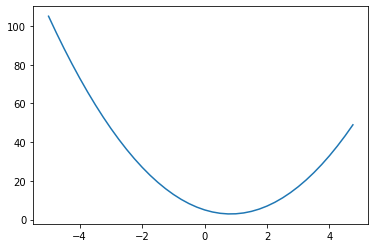

In [198]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [199]:
h = 0.00000000001
x = 3.0
(f(x + h) - f(x)) / h #get the numerical approximation of the slope

13.000089893466793

In [200]:
# let's get more compex
a = 2.0
b = -3.0
c = 10
d = a*b+c
print(d)

4.0


In [201]:
h = 0.00001

#inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [202]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')    

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
        
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [203]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L1 = L.data

In [204]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') nod for it
        dot.node(name=uid, label = "{%s | data %.4f | grad %0.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # conect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

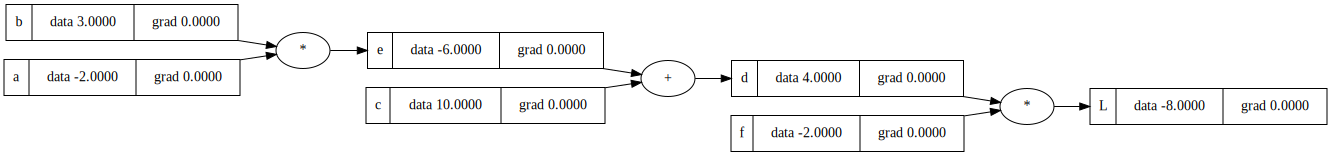

In [205]:
draw_dot(L)

In [206]:
# L = d * f
# dL / dd = ?? -> f

# (f(x + h) - f(x)) / h
# ((d + h) * f - d * f ) / h
# d*f + h*f - d*f / h
# h*f/h -> f

dd / dc
d = c + e
(f(x + h) - f(x)) / h
((c + h + e) - c - e) / h
h/h -> 1

dd / dc -> 1.0
dd / de -> 1.0

Chain rule
dz/dx = dz/dy * dy/dx
dL/dc = dL/dd * dd/dc

WANT
dL/dc

KNOW
dL/dd
dd/dc



dL / de -> -2.0

WANT
dL / da

dL / da = dL / de * de / da

e = a * b
de/da ??
de / da = 3.0
de / db = -2.0

In [207]:
a.grad = 3.0 * -2.0
b.grad = -2.0 * -2.0

In [208]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

In [209]:
def lol():
    h = 0.001

    a = Value(-2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(-2.0, label='a')
    b = Value(3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0 , label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)
lol()

3.9999999999995595


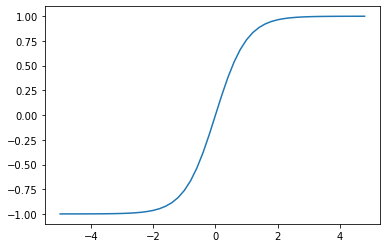

In [210]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2)))

In [211]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

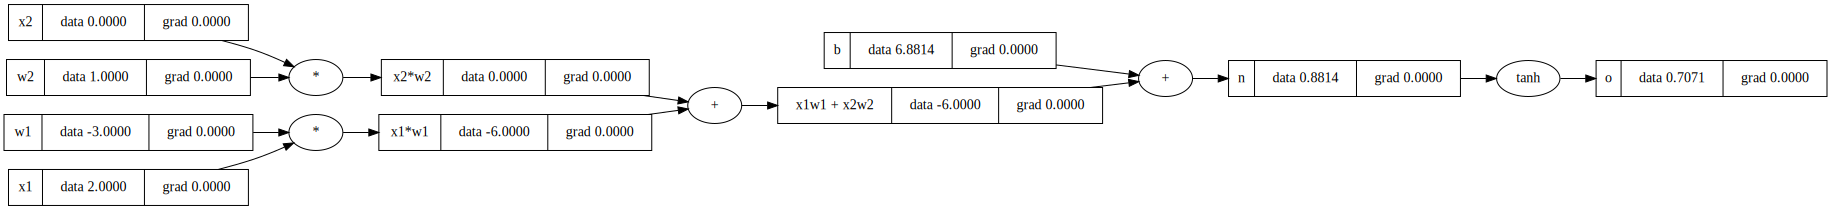

In [212]:
draw_dot(o)

In [213]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [214]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [215]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [216]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [217]:
n.grad = 0.5 # 1 = o.data**2

In [218]:
o.grad = 1.0


o = tanh(n)

do/dn = 1 - o**2

# Manual backpropagation

Backward propagation has been implemented, so we can manually call it starting from top node, which is `o` in this case

In [219]:

o.grad = 1.0


In [220]:
o._backward()

In [221]:
n._backward()

In [222]:
b._backward()

In [223]:
x1w1x2w2._backward()

In [224]:
x1w1._backward()

In [225]:
x2w2._backward()

# Automatic backpropagation

In [226]:
o.backward()

In [227]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.8813735),
 Value(data=0.8813734999999996),
 Value(data=0.7071067376767731)]

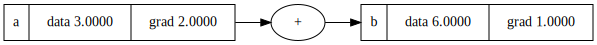

In [228]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

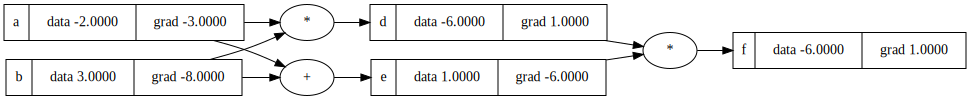

In [229]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# Implement exp, sub, div etc

In [230]:
a = Value(2.0, label='a')
1 + a

Value(data=3.0)

In [231]:
a = Value(2.0, label='a')
2 * a

Value(data=4.0)

In [232]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [233]:
a = Value(2.0)
b = Value(3.0)
a / b

Value(data=0.6666666666666666)

In [234]:
a / b
a * (1/b)
a * (b**-1)

Value(data=0.6666666666666666)

## Change how we define tanh
will be using exp, add, sub, div

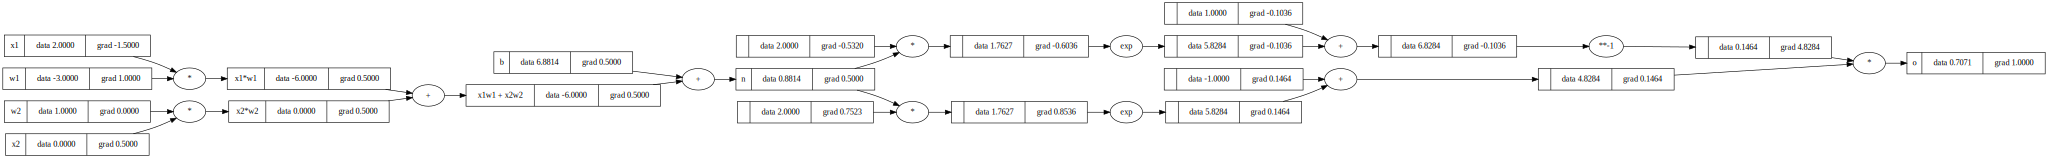

In [235]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
o = ((2*n).exp() - 1) / ((2*n).exp() + 1)
# -----
o.label = 'o'
o.backward()
draw_dot(o)

## PyTorch implementation of the same neural network

In [238]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


## Neuralnet

In [260]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: #multi layer perceptron
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [287]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7047023682108107)

In [288]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.6],
    [6.0, 1.0, 5.0],
    [1.0, 3.0, 2.0]
]
ys = [1.0, -1.0, 1.0, -1.0]


In [292]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout) ** 2 for ygt, yout in zip(ys, ypred)])

    # zero grad
    for p in n.parameters():
        p.grad = 0
    
    #backward pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.05737843094240827
1 0.05396850238730719
2 0.050914136489669755
3 0.04816421840887533
4 0.04567678042631218
5 0.04341707696064366
6 0.041356119122334355
7 0.03946954739483023
8 0.03773675590689847
9 0.03614020588834147
10 0.034664882797999605
11 0.03329786358396572
12 0.03202796911111576
13 0.030845482998277905
14 0.029741922645280628
15 0.028709851579041542
16 0.027742724741503383
17 0.0268347602148438
18 0.025980832297036918
19 0.025176381922327566


In [285]:
ypred

[Value(data=0.9407370395025909),
 Value(data=-0.795905885197826),
 Value(data=-0.7598473043599155),
 Value(data=-0.6021922757091003)]